# Final Project: Evaluating a Sequence Labelling System

This notebooks contains a basic implementation that reads Universal Dependency datasets and trains a sequence labelling model. You are free to use other datasets, other models, explore the hyperparameters, try various label sets.

Follow the instructions [here](https://pypi.org/project/conllu/) to install ```conllu```, [here](https://www.nltk.org/index.html) to install ```nltk``` and [here](https://pypi.org/project/python-crfsuite/) to install crfsuite. I recommend you use a conda environemnt for that.

We start by importing a reader for the [CONLL-U data format]() and the ```nltk``` [sequence taggers](https://www.nltk.org/api/nltk.tag.html?highlight=nltk+tag#module-nltk.tag). 



In [98]:
import random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from conllu import parse
from nltk.tag import hmm, crf, perceptron, pos_tag
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, mean_squared_error, log_loss, cohen_kappa_score

[Universal Dependencies](https://universaldependencies.org/) is a great project that releases annotations for dependency relations on corpora of various languages. You are free to download any one (or many!) of your preference. This example is using the [ATIS dataset](https://github.com/UniversalDependencies/UD_English-Atis) in English, which contains a very constrained domain and therefore a small vocabulary.

In [2]:
CORPUS_PATH = Path('UD_English-Atis-master/')

TRAIN_PATH = CORPUS_PATH / 'en_atis-ud-train.conllu'
VAL_PATH = CORPUS_PATH / 'en_atis-ud-dev.conllu'
TEST_PATH = CORPUS_PATH / 'en_atis-ud-test.conllu'

Load the three splits (train, validation/development and test). The conllu.parse method reads and creates the structure for us.

In [3]:
with open(TRAIN_PATH, 'r') as file:
    train_data = parse(file.read())

with open(VAL_PATH, 'r') as file:
    val_data = parse(file.read())

with open(TEST_PATH, 'r') as file:
    test_data = parse(file.read())

Inspecting the data format:

In [4]:
train_data[0]

TokenList<what, is, the, cost, of, a, round, trip, flight, from, pittsburgh, to, atlanta, beginning, on, april, twenty, fifth, and, returning, on, may, sixth, metadata={sent_id: "0001.train", text: "what is the cost of a round trip flight from pittsburgh to atlanta beginning on april twenty fifth and returning on may sixth"}>

In [5]:
train_data[0][7]

{'id': 8,
 'form': 'trip',
 'lemma': 'trip',
 'upos': 'NOUN',
 'xpos': None,
 'feats': {'Number': 'Sing'},
 'head': 7,
 'deprel': 'compound',
 'deps': None,
 'misc': None}

Each token contains ten categories, as described [here](https://universaldependencies.org/format.html). ```form``` is the token. For POS-tagging, we could use either ```upos``` or ```xpos```. The latter is not available for all UD datasets. We could also use ```deprel``` which contains the Universal dependency relation to the HEAD of the token. It does not make too much sense to try to predict a relation without predicting the head (why?), but for the purpose of this exercise we can also try it.

To train the sequence labelling model, the data needs to by of type List(List(Tuple(str, str))), i.e. a list of sentences, where each sentence is a list of tokens, and each token is a tuple containing the token itself and its golden label.

Below, you can replace ```upos``` by the label you want to use.

In [6]:
tagged_train = [[(word['form'], word['upos']) for word in sent] for sent in train_data]
tagged_val = [[(word['form'], word['upos']) for word in sent] for sent in val_data]
tagged_test = [[(word['form'], word['upos']) for word in sent] for sent in test_data]

Let's also load only the tokens. The gold labels will be used only for evaluation, but shouldn't be passed as input to the model:

In [7]:
tokens_train = [[(word['form'], '') for word in sent] for sent in train_data]
tokens_val = [[word['form'] for word in sent] for sent in val_data]
tokens_test = [[word['form'] for word in sent] for sent in test_data]

Instantiate a tagger model and train in on the training split. You can play around with ```HMM```, ```CRF``` or ```Perceptron``` options.

For the ```CRFTagger```, you can try initialising it with different hyperparameters, as described in its [documentation](https://www.nltk.org/api/nltk.tag.crf.html).

In [8]:
# Choose one of the following pairs:

#trainer = hmm.HiddenMarkovModelTrainer()
#tagger = trainer.train_supervised(tagged_train)

tagger = crf.CRFTagger()
tagger.train(tagged_train, 'model.crf.tagger') 

#tagger = perceptron.PerceptronTagger(load=False)
#tagger.train(tagged_train) 

Get the tags for an example sentence:

In [9]:
tagger.tag("i would like a flight from atlanta to boston .".split())

[('i', 'PRON'),
 ('would', 'AUX'),
 ('like', 'VERB'),
 ('a', 'DET'),
 ('flight', 'NOUN'),
 ('from', 'ADP'),
 ('atlanta', 'PROPN'),
 ('to', 'ADP'),
 ('boston', 'PROPN'),
 ('.', 'PROPN')]

Get the tags for the whole validation set:

In [10]:
model_outputs = tagger.tag_sents(tokens_val)

In [11]:
tokens_val[0]

['i',
 'would',
 'like',
 'the',
 'cheapest',
 'flight',
 'from',
 'pittsburgh',
 'to',
 'atlanta',
 'leaving',
 'april',
 'twenty',
 'fifth',
 'and',
 'returning',
 'may',
 'sixth']

In [12]:
model_outputs[0]

[('i', 'PRON'),
 ('would', 'AUX'),
 ('like', 'VERB'),
 ('the', 'DET'),
 ('cheapest', 'ADJ'),
 ('flight', 'NOUN'),
 ('from', 'ADP'),
 ('pittsburgh', 'PROPN'),
 ('to', 'ADP'),
 ('atlanta', 'PROPN'),
 ('leaving', 'VERB'),
 ('april', 'NOUN'),
 ('twenty', 'NUM'),
 ('fifth', 'ADJ'),
 ('and', 'CCONJ'),
 ('returning', 'VERB'),
 ('may', 'NOUN'),
 ('sixth', 'ADJ')]

In [13]:
tagged_test[0]

[('what', 'PRON'),
 ('are', 'AUX'),
 ('the', 'DET'),
 ('coach', 'NOUN'),
 ('flights', 'NOUN'),
 ('between', 'ADP'),
 ('dallas', 'PROPN'),
 ('and', 'CCONJ'),
 ('baltimore', 'PROPN'),
 ('leaving', 'VERB'),
 ('august', 'NOUN'),
 ('tenth', 'ADJ'),
 ('and', 'CCONJ'),
 ('returning', 'VERB'),
 ('august', 'NOUN'),
 ('twelve', 'NUM')]

With the model's outputs and the gold labels, you can proceed with the evaluation :)

You can also use other datasets beyond Universal Dependencies. All you need is to load the sequence of tokens and their labels in the same format (a list of lists of tuples).

## Evaluation:





Instantiating Baseline and evaluating on Validation Set:



In [14]:
def baseline_pos (token_list):
    pos_tags = ["ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SCONJ","SYM","VERB","X"]
    output = []
    for sent in token_list:
        output_sent = []
        for token in sent:
            if len(token) > 7:
                pos = "PROPN"
            if len(token) == 1:
                pos = "PRON"
            if len(token) in range(3-5):
                pos = "VERB"
            else:
                pos = random.choice(pos_tags)
            output_sent.append((token, pos))
        output.append(output_sent)
    return output

def nltk_pos(token_list):
    output = []
    for sent in token_list:
        output.append(pos_tag(sent, tagset="universal"))
    return output


In [15]:
base_output = nltk_pos(tokens_val)

In [16]:
base_output[0]

[('i', 'NOUN'),
 ('would', 'VERB'),
 ('like', 'VERB'),
 ('the', 'DET'),
 ('cheapest', 'ADJ'),
 ('flight', 'NOUN'),
 ('from', 'ADP'),
 ('pittsburgh', 'NOUN'),
 ('to', 'PRT'),
 ('atlanta', 'VERB'),
 ('leaving', 'VERB'),
 ('april', 'ADJ'),
 ('twenty', 'NOUN'),
 ('fifth', 'NOUN'),
 ('and', 'CONJ'),
 ('returning', 'NOUN'),
 ('may', 'VERB'),
 ('sixth', 'VERB')]

In [17]:
def accuracy(data, gold):
    equal = 0
    n = 0
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] == gold[i][j]:
                equal += 1
            n += 1
    acc = equal / n
    return acc
    
print(accuracy(base_output, tagged_val))

0.5388320288982541


In [18]:
model_outputs[0]

[('i', 'PRON'),
 ('would', 'AUX'),
 ('like', 'VERB'),
 ('the', 'DET'),
 ('cheapest', 'ADJ'),
 ('flight', 'NOUN'),
 ('from', 'ADP'),
 ('pittsburgh', 'PROPN'),
 ('to', 'ADP'),
 ('atlanta', 'PROPN'),
 ('leaving', 'VERB'),
 ('april', 'NOUN'),
 ('twenty', 'NUM'),
 ('fifth', 'ADJ'),
 ('and', 'CCONJ'),
 ('returning', 'VERB'),
 ('may', 'NOUN'),
 ('sixth', 'ADJ')]

## Hyperparameter Tuning


Base Tagger with default parameters:

In [19]:
tagger = crf.CRFTagger()
tagger.train(tagged_train, 'model.crf.tagger')
model_outputs = tagger.tag_sents(tokens_val)
print(accuracy(model_outputs, tagged_val))

0.9793798916315473


Tuning of L1 and L2 (c1 and c2) coefficient: Closing in the range:

In [20]:
tagger = crf.CRFTagger(verbose=False, training_opt={'c1':0, "c2":0.1})
tagger.train(tagged_train, 'model.crf.tagger')
model_outputs = tagger.tag_sents(tokens_val)
print(accuracy(model_outputs, tagged_val))

0.9844972907886815


c1: 0.5 c2: 1.0 Acc: 0.9783263094521373 -  
c1: 0   c2: 0.5 Acc: 0.9814870559903672 +  
c1: 0   c2: 0.3 Acc: 0.9831426851294401 +  
c1: 1   c2: 2.0 Acc: 0.9729078868151716 -  
c1: 1   c2: 1.3 Acc: 0.975316074653823 -  
c1: 0   c2: 0.1 Acc: 0.9844972907886815 +  

In [21]:
tagger = crf.CRFTagger(verbose=False, training_opt={'c1':0, "c2":0.1, 'feature.possible_states':0, 'feature.possible_transitions':1})
tagger.train(tagged_train, 'model.crf.tagger')
model_outputs = tagger.tag_sents(tokens_val)
print(accuracy(model_outputs, tagged_val))

0.9847983142685129


In [22]:
tagger = crf.CRFTagger(verbose=False, training_opt={'c1':0, "c2":0.1, 'feature.possible_states':0, 'feature.possible_transitions':1})
tagger.train(tagged_train, 'model.crf.tagger')
model_outputs = tagger.tag_sents(tokens_val)
print(accuracy(model_outputs, tagged_val))

0.9847983142685129


Forcing generation of features:  

possible_states: 1 possible_transitions: 0 Acc: 0.9846478025285972 +   
possible_states: 1 possible_transitions: 1 Acc: 0.9846478025285972 +  
possible_states: 0 possible_transitions: 1 Acc: 0.9847983142685129 +  

In [23]:
tagger = crf.CRFTagger(verbose=True, training_opt={'c1':0, "c2":0.1, 'feature.possible_states':0, 'feature.possible_transitions':1})
tagger.train(tagged_train, 'model.crf.tagger')
model_outputs = tagger.tag_sents(tokens_val)
print(accuracy(model_outputs, tagged_val))

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 2172
Seconds required: 0.039

L-BFGS optimization
c1: 0.000000
c2: 0.100000
num_memories: 6
max_iterations: 2147483647
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 67526.440165
Feature norm: 5.000000
Error norm: 7207.015092
Active features: 2172
Line search trials: 2
Line search step: 0.000318
Seconds required for this iteration: 0.205

***** Iteration #2 *****
Loss: 47854.768814
Feature norm: 8.563556
Error norm: 4790.706495
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.070

***** Iteration #3 *****
Loss: 31980.725165
Feature norm: 13.896194
Error norm: 3416.439279
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required fo

***** Iteration #41 *****
Loss: 3090.315005
Feature norm: 92.554737
Error norm: 37.296415
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.078

***** Iteration #42 *****
Loss: 3080.797472
Feature norm: 92.798310
Error norm: 39.729103
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.070

***** Iteration #43 *****
Loss: 3067.726188
Feature norm: 93.560193
Error norm: 85.860566
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.077

***** Iteration #44 *****
Loss: 3056.302614
Feature norm: 94.113073
Error norm: 44.424799
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.078

***** Iteration #45 *****
Loss: 3050.602832
Feature norm: 94.030377
Error norm: 28.310597
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required fo

***** Iteration #81 *****
Loss: 2943.361071
Feature norm: 88.558939
Error norm: 7.948311
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.063

***** Iteration #82 *****
Loss: 2943.021851
Feature norm: 88.532672
Error norm: 7.350516
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.067

***** Iteration #83 *****
Loss: 2942.538812
Feature norm: 88.483460
Error norm: 7.460975
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.061

***** Iteration #84 *****
Loss: 2942.244918
Feature norm: 88.423694
Error norm: 11.450455
Active features: 2172
Line search trials: 2
Line search step: 0.489857
Seconds required for this iteration: 0.124

***** Iteration #85 *****
Loss: 2941.906245
Feature norm: 88.385911
Error norm: 6.459882
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for th

***** Iteration #125 *****
Loss: 2938.142220
Feature norm: 88.419615
Error norm: 1.341897
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.065

***** Iteration #126 *****
Loss: 2938.133291
Feature norm: 88.432995
Error norm: 1.892730
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.061

***** Iteration #127 *****
Loss: 2938.118126
Feature norm: 88.452958
Error norm: 1.995556
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.064

***** Iteration #128 *****
Loss: 2938.100678
Feature norm: 88.470130
Error norm: 1.517928
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.059

***** Iteration #129 *****
Loss: 2938.088423
Feature norm: 88.482908
Error norm: 1.891839
Active features: 2172
Line search trials: 1
Line search step: 1.000000
Seconds required fo

## Testing 

Setup:  
Fine-tuned CRFTagger on test set  
Annotated test set as gold standard  
Both baselines on test set  



In [67]:
tagger = crf.CRFTagger(verbose=False, training_opt={'c1':0, "c2":0.1, 'feature.possible_states':0, 'feature.possible_transitions':1})
tagger.train(tagged_train, 'model.crf.tagger')
model_outputs = tagger.tag_sents(tokens_test)
gold = tagged_test
baseline_r = baseline_pos(tokens_test)
baseline_nltk = nltk_pos(tokens_test)


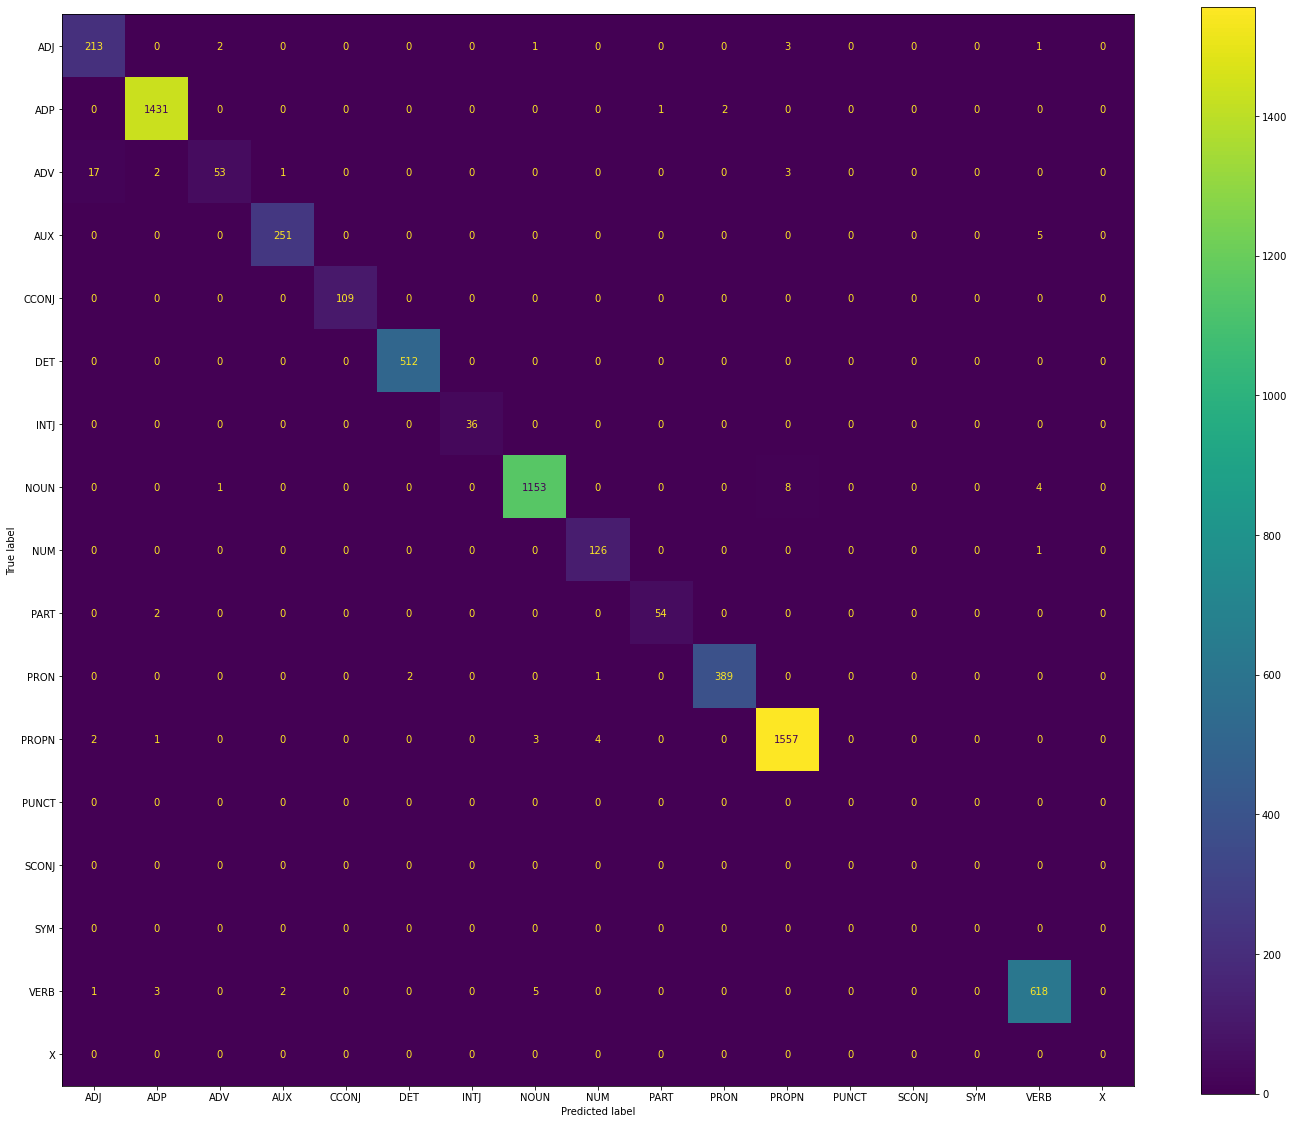

In [25]:
#Create arrays for confusion matrix 

model_tags = []
for sent in model_outputs:
    for token in sent:
        model_tags.append(token[1])

gold_tags = []
for sent in gold:
    for token in sent:
        gold_tags.append(token[1])

labels = ["ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SCONJ","SYM","VERB","X"]
cm = confusion_matrix(gold_tags, model_tags, labels=labels)

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
plt.rcParams["figure.figsize"] = (24,20)
disp.plot()
plt.show()

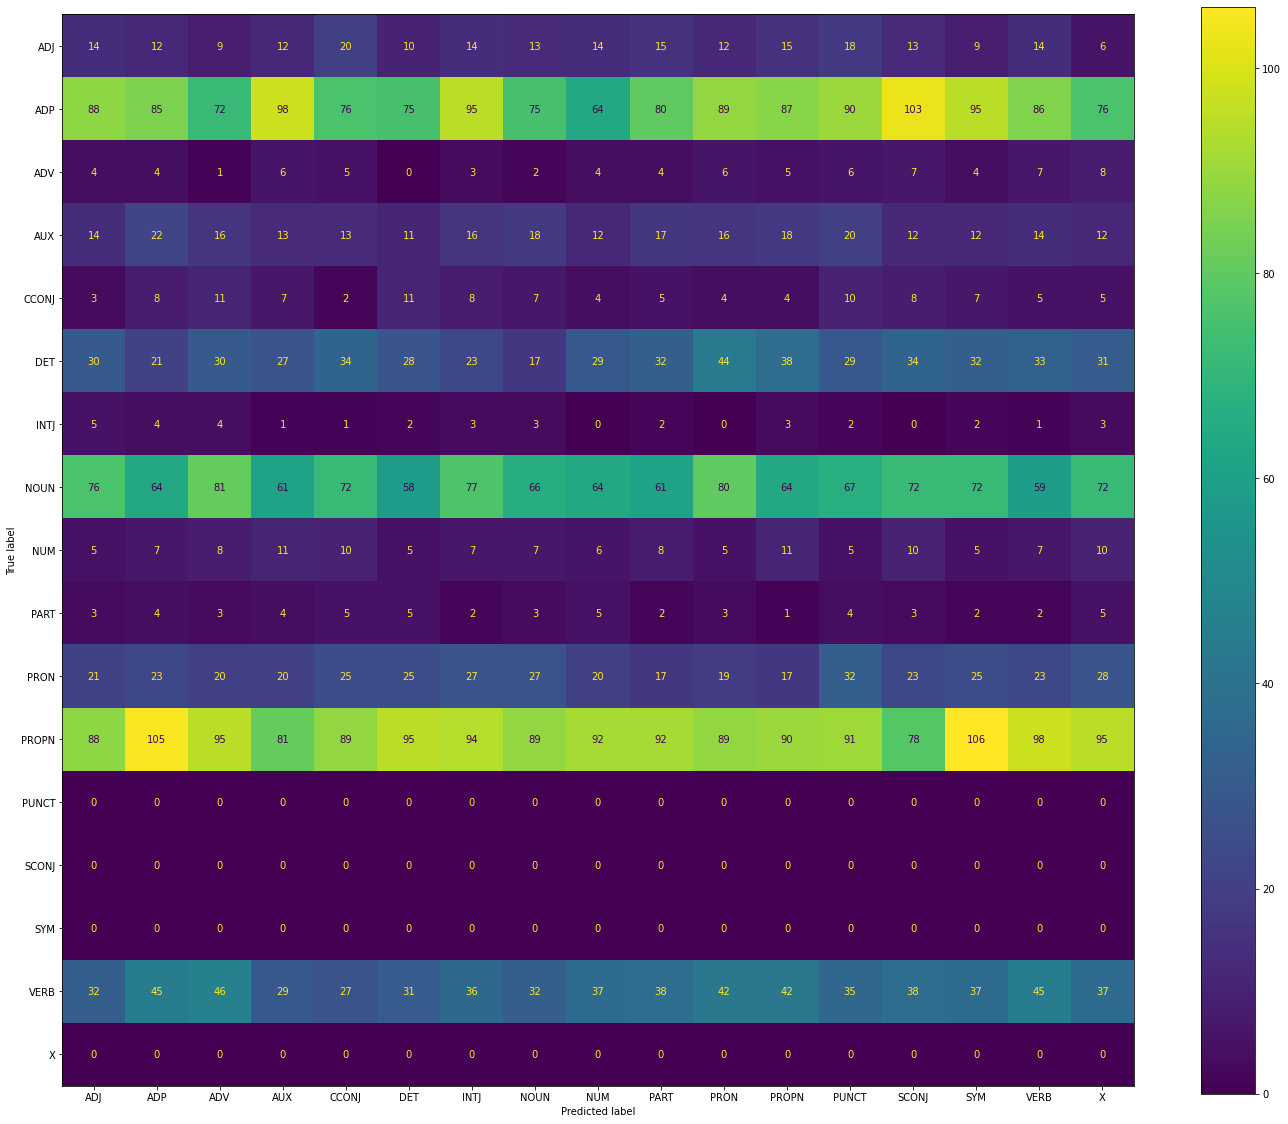

In [26]:
base_tags = []
for sent in baseline_r:
    for token in sent:
        base_tags.append(token[1])
        
labels = ["ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SCONJ","SYM","VERB","X"]
cm = confusion_matrix(gold_tags, base_tags, labels=labels)

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
plt.rcParams["figure.figsize"] = (24,20)
disp.plot()
plt.show()

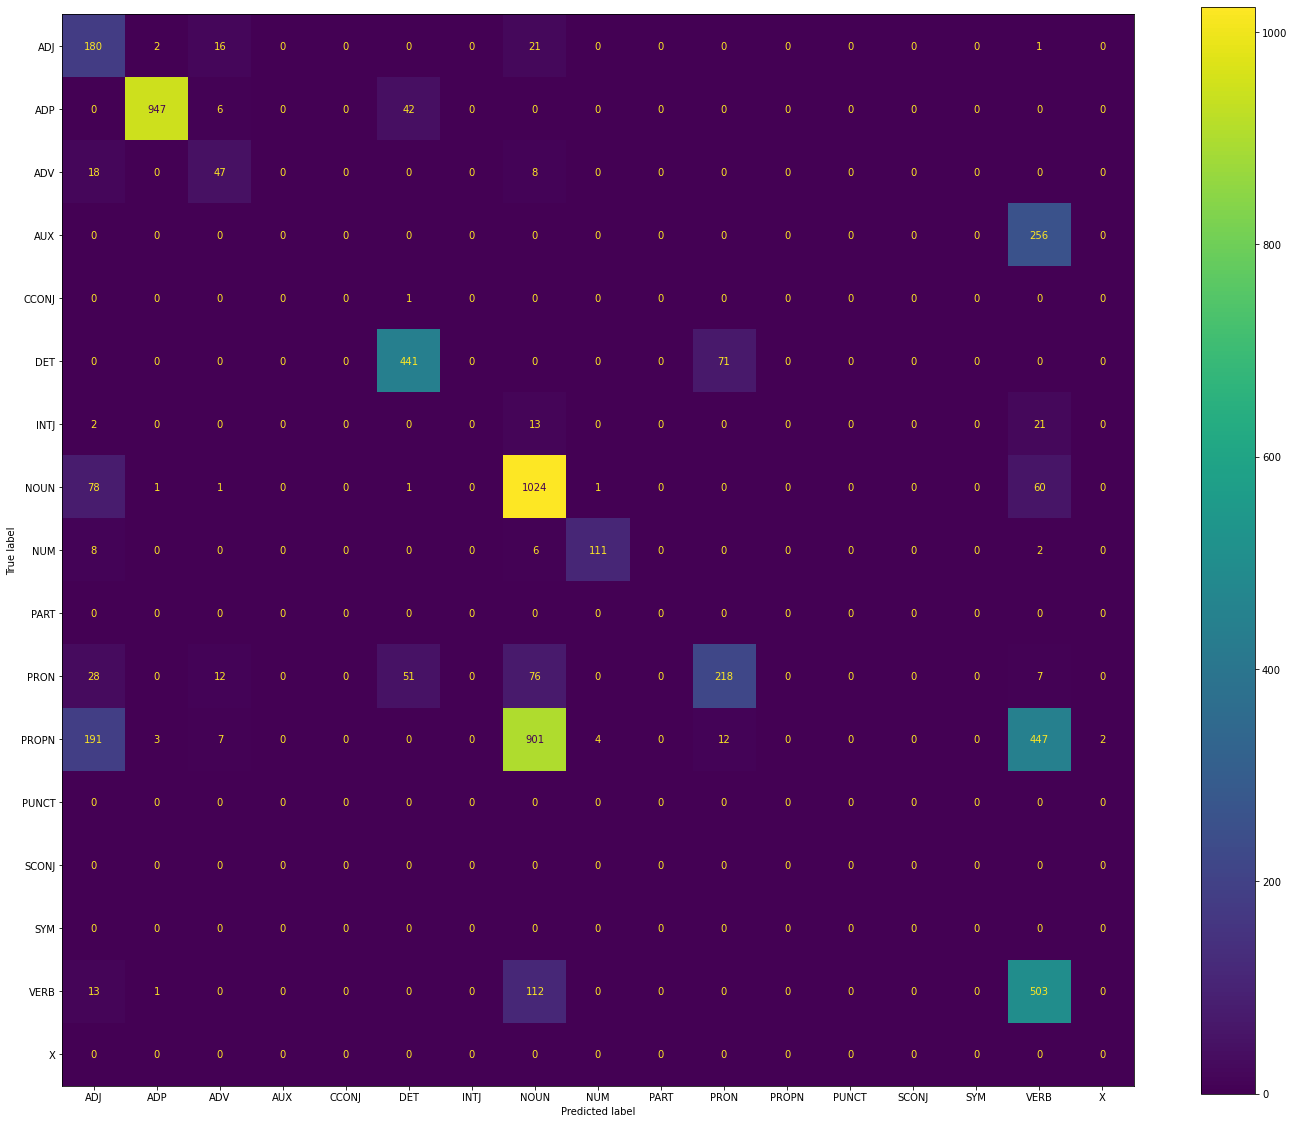

In [27]:
base_tags = []
for sent in baseline_nltk:
    for token in sent:
        base_tags.append(token[1])
        
labels = ["ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SCONJ","SYM","VERB","X"]
cm = confusion_matrix(gold_tags, base_tags, labels=labels)

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
plt.rcParams["figure.figsize"] = (24,20)
disp.plot()
plt.show()

### Accuracy

In [28]:
print(accuracy(model_outputs, tagged_test))

0.988145896656535


In [29]:
print(accuracy(baseline_nltk, tagged_test))

0.5275075987841945


### Precision

In [30]:
print(precision_score(gold_tags, model_tags, average="weighted"))

0.9881748401608401


In [31]:
print(precision_score(gold_tags, base_tags, average="weighted"))

0.48072939061693165


C:\Users\Icke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Recall

In [32]:
print(recall_score(gold_tags, model_tags, average="weighted"))

0.988145896656535


In [33]:
print(precision_score(gold_tags, base_tags,average="weighted"))

0.48072939061693165


C:\Users\Icke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### F1 weighted average

In [34]:
print(f1_score(gold_tags, model_tags, average="weighted"))

0.9879087775772045


In [35]:
f1 = f1_score(gold_tags, base_tags, average="weighted")
print(f1)

0.4753517851601098


In [36]:
f1_micro_t = f1_score(gold_tags, model_tags, average="micro")
f1_macro_t = f1_score(gold_tags, model_tags, average="macro")
f1_weighted_t = f1_score(gold_tags, model_tags, average="weighted")

f1_micro_b = f1_score(gold_tags, base_tags, average="micro")
f1_macro_b = f1_score(gold_tags, base_tags, average="macro")
f1_weighted_b = f1_score(gold_tags, base_tags, average="weighted")

print("micro t",f1_micro_t)
print("macro t", f1_macro_t)
print("weighted t",f1_weighted_t)
print("micro b",f1_micro_b)
print("macro b", f1_macro_b)
print("weighted b",f1_weighted_b)

micro t 0.988145896656535
macro t 0.971592949433023
weighted t 0.9879087775772045
micro b 0.5275075987841945
macro b 0.3358038595087258
weighted b 0.4753517851601098


### Mean squared error

In [37]:
#e =  mean_squared_error(np.array(gold_tags), np.array(model_tags), multioutput = "raw-values")

### Log Loss

In [64]:
from sklearn.preprocessing import OneHotEncoder

# Create example y_true and y_pred arrays with different numbers of classes
y_true = ['cat', 'dog', 'bird', 'cat', 'bird', 'dog']
y_pred = ['dog', 'cat', 'bird', 'bird', 'dog']

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Instantiate a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on the combined y_true and y_pred arrays
encoder.fit(list(set(y_true + y_pred)).reshape(-1, 1))

# Transform y_true and y_pred using the fitted encoder
y_true_encoded = encoder.transform(np.array(y_true).reshape(-1, 1))
y_pred_encoded = encoder.transform(np.array(y_pred).reshape(-1, 1))

# Compute the evaluation metric(s) on the encoded y_true and y_pred arrays
# For example, you can compute the accuracy as follows:
accuracy = np.mean(y_true_encoded.argmax(axis=1) == y_pred_encoded.argmax(axis=1))

#l = log_loss(gold_encoded, model_encoded)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U4'), dtype('<U4')) -> dtype('<U4')

### Cohens Kappa

In [77]:
tagger = crf.CRFTagger(verbose=False, training_opt={'c1':0, "c2":0.1, 'feature.possible_states':0, 'feature.possible_transitions':1})
tagger.train(tagged_train, 'model.crf.tagger')
model_outputs = tagger.tag_sents(tokens_test)
gold = tagged_test
baseline_r = baseline_pos(tokens_test)
baseline_nltk = nltk_pos(tokens_test)

#Create arrays for confusion matrix 

model_tags = []
for sent in model_outputs:
    for token in sent:
        model_tags.append(token[1])

gold_tags = []
for sent in gold:
    for token in sent:
        gold_tags.append(token[1])

base_tags_r = []
for sent in baseline_r:
    for token in sent:
        base_tags_r.append(token[1])
        
base_tags_n = []
for sent in baseline_nltk:
    for token in sent:
        base_tags_n.append(token[1])
        

In [79]:
ck_tagger = cohen_kappa_score(gold_tags, model_tags)
ck_r = cohen_kappa_score(gold_tags, base_tags_r)
ck_nltk = cohen_kappa_score(gold_tags, base_tags_n)
print("Tagger", ck_tagger)
print("Random", ck_r)
print("NLTK", ck_nltk)

Tagger 0.9859196158319001
Random -0.001549789136355395
NLTK 0.4625706145115933


### Comparison with similar dataset

In [ ]:
tagger = crf.CRFTagger(verbose=False, training_opt={'c1':0, "c2":0.1, 'feature.possible_states':0, 'feature.possible_transitions':1})
tagger.train(tagged_train, 'model.crf.tagger')

In [ ]:
CORPUS_PATH_2 = Path('UD_English-ParTUT-master/')

TRAIN_PATH_2 = CORPUS_PATH_2 / 'en_partut-ud-train.conllu'
VAL_PATH_2 = CORPUS_PATH_2 / 'en_partut-ud-dev.conllu'
TEST_PATH_2 = CORPUS_PATH_2 / 'en_partut-ud-test.conllu'

with open(TRAIN_PATH_2, 'r') as file:
    train_data_2 = parse(file.read())

with open(VAL_PATH_2, 'r') as file:
    val_data_2 = parse(file.read())

with open(TEST_PATH_2, 'r') as file:
    test_data_2 = parse(file.read())
    
tagged_train_2 = [[(word['form'], word['upos']) for word in sent] for sent in train_data_2]
tagged_val_2 = [[(word['form'], word['upos']) for word in sent] for sent in val_data_2]
tagged_test_2 = [[(word['form'], word['upos']) for word in sent] for sent in test_data_2]

tokens_train_2 = [[(word['form'], '') for word in sent] for sent in train_data_2]
tokens_val_2 = [[word['form'] for word in sent] for sent in val_data_2]
tokens_test_2 = [[word['form'] for word in sent] for sent in test_data_2]

#tagger = crf.CRFTagger(verbose=False, training_opt={'c1':0, "c2":0.1, 'feature.possible_states':0, 'feature.possible_transitions':1})
#tagger.train(tagged_train, 'model.crf.tagger')
model_outputs = tagger.tag_sents(tokens_test_2)
gold = tagged_test_2
baseline_r = baseline_pos(tokens_test_2)
baseline_nltk = nltk_pos(tokens_test_2)

In [ ]:
print(accuracy(model_outputs, gold))

In [ ]:
print(accuracy(baseline_nltk, gold))

In [ ]:
print(accuracy(baseline_r, gold))